##### Copyright 2019 The TensorFlow Authors. [Licensed under the Apache License, Version 2.0](#scrollTo=y_UVSRtBBsJk).

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
// Licensed under the Apache License, Version 2.0 (the "License");
// you may not use this file except in compliance with the License.
// You may obtain a copy of the License at
//
// https://www.apache.org/licenses/LICENSE-2.0
//
// Unless required by applicable law or agreed to in writing, software
// distributed under the License is distributed on an "AS IS" BASIS,
// WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
// See the License for the specific language governing permissions and
// limitations under the License.

## **The Basics: Training Your First Model**

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/drive/1Gp5ypYsDZ3QPzgNBCUbW3h6fMj3asz9y"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="Link to be updated"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />GitHub link to be updated accordingly</a>
  </td>
</table>

Welcome to this Colab where you will train your first Machine Learning model!

We'll try to keep things simple here, and only introduce basic concepts. Later Colabs will cover more advanced problems.

The problem we will solve is to convert from Celsius to Fahrenheit, where the approximate formula is:

$$ f = c \times 1.8 + 32 $$


Of course, it would be simple enough to create a conventional Python function that directly performs this calculation, but that wouldn't be machine learning.


Instead, we will give TensorFlow some sample Celsius values (0, 8, 15, 22, 38) and their corresponding Fahrenheit values (32, 46, 59, 72, 100).
Then, we will train a model that figures out the above formula through the training process.

In [0]:
import TensorFlow

import Python
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")
let plt = Python.import("matplotlib.pyplot")

let np = Python.import("numpy")  // Make numpy available using np.

## Set up Training Data

As we saw before, supervised Machine Learning is all about figuring out an algorithm given a set of inputs and outputs. Since the task in this Codelab is to create a model that can give the temperature in Fahrenheit when given the degrees in Celsius, we create two lists `celsiusTemperatures` and `fahrenheitTemperatures` that we can use to train our model.

In [3]:
let celsiusTemperatures: [Float] = [-40, -10,  0,  8, 15, 22,  38]
let input = Tensor<Float>(shape: [7, 1], scalars: celsiusTemperatures)
let fahrenheitTemperatures: [Float] = [-40, 14, 32, 46, 59, 72, 100]
let output = Tensor<Float>(shape: [7, 1], scalars: fahrenheitTemperatures)

for (index, celsiusTemperature) in celsiusTemperatures.enumerated() {
    print("\(celsiusTemperature) degrees Celsius = \(fahrenheitTemperatures[index]) degrees Fahrenheit")
}

-40.0 degrees Celsius = -40.0 degrees Fahrenheit
-10.0 degrees Celsius = 14.0 degrees Fahrenheit
0.0 degrees Celsius = 32.0 degrees Fahrenheit
8.0 degrees Celsius = 46.0 degrees Fahrenheit
15.0 degrees Celsius = 59.0 degrees Fahrenheit
22.0 degrees Celsius = 72.0 degrees Fahrenheit
38.0 degrees Celsius = 100.0 degrees Fahrenheit


### Some Machine Learning terminology

 - **Feature** — The input(s) to our model. In this case, a single value — the degrees in Celsius.

 - **Labels** — The output our model predicts. In this case, a single value — the degrees in Fahrenheit.
 
 - **Example** — A pair of inputs/outputs used during training. In our case a pair of values from `celsiusTemperatures` and `fahrenheitTemperatures` at a specific index, such as `(22, 72)`.




### Why model?

A *[model](https://developers.google.com/machine-learning/crash-course/glossary#model)* is a relationship between features and the label.  For the Celsius to Fahrenheit Conersion problem, the model defines the relationship between the Celsius Temperature and Fahrenheit Temperatures. Some simple models can be described with a few lines of algebra, but complex machine learning models have a large number of parameters that are difficult to summarize.

Could you determine the relationship between the two *without* using machine learning?  That is, could you use traditional programming techniques (for example, a lot of conditional statements) to create a model?  Perhaps—if you analyzed the dataset long enough to determine the relationships between temperatures. And this becomes difficult—maybe impossible—on more complicated datasets. A good machine learning approach *determines the model for you*. If you feed enough representative examples into the right machine learning model type, the program will figure out the relationships for you.

### Select the model

We need to select the kind of model to train. We will use simplest possible model we can, a Dense network. Since the problem is straightforward, this network will require only a single layer, with a single neuron. 



### Create a model using the Swift for TensorFlow Deep Learning Library

The [Swift for TensorFlow Deep Learning Library](https://github.com/tensorflow/swift-apis) defines primitive layers and conventions for wiring them together, which makes it easy to build models and experiment.

A model is a `struct` that conforms to [`Layer`](https://www.tensorflow.org/swift/api_docs/Protocols/Layer), which means that it defines a [`callAsFunction(_:)`](https://www.tensorflow.org/swift/api_docs/Protocols/Layer) method that maps input `Tensor`s to output `Tensor`s. The `callAsFunction(_:)` method often simply sequences the input through sublayers. Let's define an `CelsiusToFahrenheit` that sequences the input through a single [`Dense`](https://www.tensorflow.org/swift/api_docs/Structs/Dense) layer.

*   `inputSize: 1` — This specifies that the input to this layer is a single value. Since this is the first (and only) layer, that input shape is the input shape of the entire model. The single value is a Tensor matrix of floating point numbers, representing degrees Celsius.

* `outputSize: 1` — This specifies that the output of this layer is a single value. The single value is a tensor matrix of floating point numbers, representing degrees Fahrenheit.

In [0]:
struct CelsiusToFahrenheit: Layer {
    var l0 = Dense<Float>(inputSize: 1, outputSize: 1)
  
    @differentiable
    func callAsFunction(_ input: Tensor<Float>) -> Tensor<Float> {
        return l0(input)
    }
}

var model = CelsiusToFahrenheit()

### Create an optimizer

An *[optimizer](https://developers.google.com/machine-learning/crash-course/glossary#optimizer)* applies the computed gradients to the model's variables to minimize the `loss` function. You can think of the loss function as a curved surface (see Figure 3) and we want to find its lowest point by walking around. The gradients point in the direction of steepest ascent—so we'll travel the opposite way and move down the hill. By iteratively calculating the loss and gradient for each batch, we'll adjust the model during training. Gradually, the model will find the best combination of weights and bias to minimize loss. And the lower the loss, the better the model's predictions.

<table>
  <tr><td>
    <img src="https://cs231n.github.io/assets/nn3/opt1.gif" width="70%"
         alt="Optimization algorithms visualized over time in 3D space.">
  </td></tr>
  <tr><td align="center">
    <b>Figure 3.</b> Optimization algorithms visualized over time in 3D space.<br/>(Source: <a href="http://cs231n.github.io/neural-networks-3/">Stanford class CS231n</a>, MIT License, Image credit: <a href="https://twitter.com/alecrad">Alec Radford</a>)
  </td></tr>
</table>

Swift for TensorFlow has many [optimization algorithms](https://github.com/rxwei/DeepLearning/blob/master/Sources/DeepLearning/Optimizer.swift) available for training. This model uses the Adam optimizer that implements the *[Adam Algorithm](http://arxiv.org/abs/1412.6980). 

During training, the optimizer function is used to calculate adjustments to the model's internal variables. The goal is to adjust the internal variables until the model (which is really a math function) mirrors the actual equation for converting Celsius to Fahrenheit.

TensorFlow uses numerical analysis to perform this tuning, and all this complexity is hidden from you so we will not go into the details here. What is useful to know about these parameters are:

The loss function ([mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error)) and the optimizer ([Adam](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)) used here are standard for simple models like this one, but many others are available. It is not important to know how these specific functions work at this point.

One part of the Optimizer you may need to think about when building your own models is the learning rate (`0.1` in the code above). This is the step size taken when adjusting values in the model. If the value is too small, it will take too many iterations to train the model. Too large, and accuracy goes down. Finding a good value often involves some trial and error, but the range is usually within 0.001 (default), and 0.1

In [0]:
let optimizer = Adam(for: model, learningRate: 0.1)

In [0]:
Context.local.learningPhase = .training

In [0]:
let epochCount = 500
var trainLossResults: [Float] = []

### Training loop

With all the pieces in place, the model is ready for training! A training loop feeds the dataset examples into the model to help it make better predictions. The following code block sets up these training steps:

1. Iterate each *epoch*. An epoch is one pass through the dataset.
2. Within an epoch, iterate over each example in the training `Dataset` grabbing its *features* (`x`) and *label* (`y`).
3. Using the example's features, make a prediction and compare it with the label. Measure the inaccuracy of the prediction and use that to calculate the model's loss and gradients.
4. Use Adam Algorithm to update the model's variables.
5. Keep track of some stats for visualization.
6. Repeat for each epoch.

The `epochCount` variable is the number of times to loop over the dataset collection. Counter-intuitively, training a model longer does not guarantee a better model. `epochCount` is a *[hyperparameter](https://developers.google.com/machine-learning/glossary/#hyperparameter)* that you can tune. Choosing the right number usually requires both experience and experimentation.

### Choose a loss function

Both training and evaluation stages need to calculate the model's *[loss](https://developers.google.com/machine-learning/crash-course/glossary#loss)*. This measures how off a model's predictions are from the desired label, in other words, how bad the model is performing. We want to minimize, or optimize, this value.

Our model will calculate its loss using the [`meanSquaredError(predicted:expected:)`](https://www.tensorflow.org/swift/api_docs/Functions#meansquarederrorpredicted:expected:) function which takes the model's class ouput predictions and the desired label, and returns the mean squared error across the examples.

In [8]:
func accuracy(predictions: Tensor<Float>, truths: Tensor<Float>) -> Float {
    return Tensor<Float>(predictions .== truths).mean().scalarized()
}

for epoch in 1...epochCount {
    var epochLoss: Float = 0
    let (loss, grad) = model.valueWithGradient { model -> Tensor<Float> in
        let pred = model(input)
        return meanSquaredError(predicted: pred, expected: output)
    }
    optimizer.update(&model.allDifferentiableVariables, along: grad)
    epochLoss = loss.scalarized()
    trainLossResults.append(epochLoss)
    if epoch.isMultiple(of: 20) {
        print("Epoch \(epoch): Loss: \(loss)")
    }
}

Epoch 20: Loss: 881.729
Epoch 40: Loss: 767.57764
Epoch 60: Loss: 670.0495
Epoch 80: Loss: 581.5847
Epoch 100: Loss: 502.45035
Epoch 120: Loss: 431.85077
Epoch 140: Loss: 369.17767
Epoch 160: Loss: 313.86273
Epoch 180: Loss: 265.33023
Epoch 200: Loss: 223.0045
Epoch 220: Loss: 186.31873
Epoch 240: Loss: 154.72224
Epoch 260: Loss: 127.68569
Epoch 280: Loss: 104.705086
Epoch 300: Loss: 85.30526
Epoch 320: Loss: 69.042564
Epoch 340: Loss: 55.50706
Epoch 360: Loss: 44.323112
Epoch 380: Loss: 35.150513
Epoch 400: Loss: 27.683872
Epoch 420: Loss: 21.652143
Epoch 440: Loss: 16.816889
Epoch 460: Loss: 12.970839
Epoch 480: Loss: 9.935408
Epoch 500: Loss: 7.5585675


### Visualize the loss function over time

While it's helpful to print out the model's training progress, it's often *more* helpful to see this progress. We can create basic charts using Python's `matplotlib` module.

Interpreting these charts takes some experience, but you really want to see the *loss* go down and the *accuracy* go up.

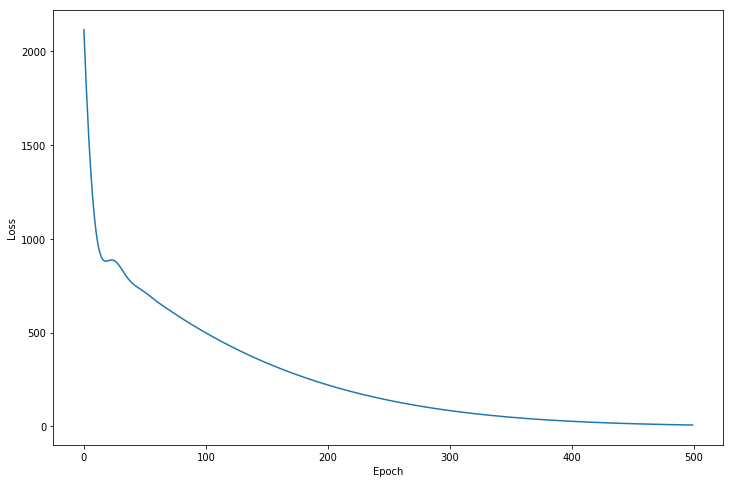

None


In [9]:
plt.figure(figsize: [12, 8])

plt.plot(trainLossResults)
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

## Use the trained model to make predictions

We've trained a model and demonstrated that it's good—but not perfect—at conerting temperatures. Now let's use the trained model to make some predictions on [unlabeled examples](https://developers.google.com/machine-learning/glossary/#unlabeled_example); that is, on examples that contain features but not a label.

In real-life, the unlabeled examples could come from lots of different sources including apps, CSV files, and data feeds. For now, we're going to manually provide degree Celsius Temperatures to predict their respective degree Fahrenheit Temperatures.

In [10]:
let unlabeledDataset: [Float] = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
let unlabeledDatasetPredictions = Tensor<Float>(shape: [10, 1], scalars: unlabeledDataset)

let pred = model(unlabeledDatasetPredictions)

print("prediction:")
print(pred)

prediction:
[[47.393456],
 [ 65.60878],
 [83.824104],
 [102.03943],
 [120.25475],
 [138.47008],
 [ 156.6854],
 [174.90073],
 [193.11606],
 [211.33138]]


**The** correct answers are 

$10 \times 1.8 + 32 = 50$

$20 \times 1.8 + 32 = 68$

$30 \times 1.8 + 32 = 86$

$40 \times 1.8 + 32 = 104$

$50 \times 1.8 + 32 = 122$

$60 \times 1.8 + 32 = 140$

$70 \times 1.8 + 32 = 158$

$80 \times 1.8 + 32 = 176$

$90 \times 1.8 + 32 = 194$

$100 \times 1.8 + 32 = 212$

, so our model is doing really well.

### To review


*   We created a model with a Dense layer
*   We trained it with 3500 examples (7 pairs, over 500 epochs).

Our model tuned the variables (weights) in the Dense layer until it was able to return the correct Fahrenheit value for any Celsius value. (Remember, none of these degree Celsius temperatures were part of our training data.)

## Looking at the layer weights

Finally, let's print the internal variables of the Dense layer. 

In [11]:
print(model.l0.weight)
print(model.l0.bias)

[[1.8215325]]
[29.178131]


The first variable is close to ~1.8 and the second to ~32. These values (1.8 and 32) are the actual variables in the real conversion formula.

This is really close to the values in the conversion formula. We'll explain this in an upcoming video where we show how a Dense layer works, but for a single neuron with a single input and a single output, the internal math looks the same as [the equation for a line](https://en.wikipedia.org/wiki/Linear_equation#Slope%E2%80%93intercept_form), $y = mx + b$, which has the same form as the conversion equation, $f = 1.8c + 32$.

Since the form is the same, the variables should converge on the standard values of 1.8 and 32, which is exactly what happened.

With additional neurons, additional inputs, and additional outputs, the formula becomes much more complex, but the idea is the same. 

### A little experiment

Just for fun, what if we created more Dense layers with different units, which therefore also has more variables?

Epoch 20: Loss: 391.65802
Epoch 40: Loss: 35.42868
Epoch 60: Loss: 5.1456184
Epoch 80: Loss: 1.0770066
Epoch 100: Loss: 0.11890763
Epoch 120: Loss: 0.06713961
Epoch 140: Loss: 0.065158285
Epoch 160: Loss: 0.06305517
Epoch 180: Loss: 0.063074574
Epoch 200: Loss: 0.0630473
Epoch 220: Loss: 0.063046604
Epoch 240: Loss: 0.06304517
Epoch 260: Loss: 0.063044794
Epoch 280: Loss: 0.06304594
Epoch 300: Loss: 0.06304648
Epoch 320: Loss: 0.06304646
Epoch 340: Loss: 0.06304664
Epoch 360: Loss: 0.063046314
Epoch 380: Loss: 0.06304726
Epoch 400: Loss: 0.06304786
Epoch 420: Loss: 0.06304669
Epoch 440: Loss: 0.06304681
Epoch 460: Loss: 0.063046865
Epoch 480: Loss: 0.06304786
Epoch 500: Loss: 0.06304671


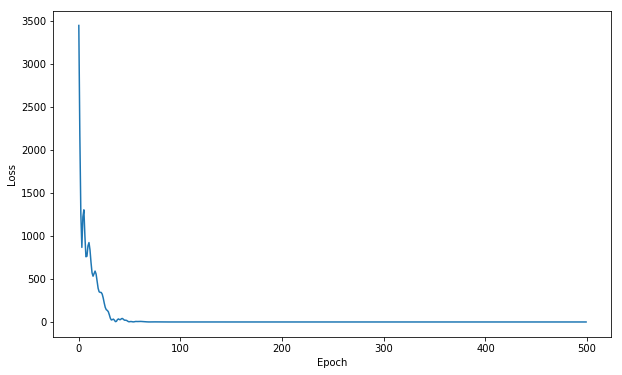

Experimental prediction:
[[49.932014],
 [ 67.91151],
 [   85.891],
 [103.87049],
 [121.84998],
 [139.82947],
 [157.80898],
 [175.78848],
 [193.76794],
 [211.74744]]


In [12]:
let hiddenSize: Int = 4
struct CelsiusToFahrenheit2: Layer {
    var layer1 = Dense<Float>(inputSize: 1, outputSize: hiddenSize)
    var layer2 = Dense<Float>(inputSize: hiddenSize, outputSize: hiddenSize)
    var layer3 = Dense<Float>(inputSize: hiddenSize, outputSize: 1)
  
    @differentiable
    func callAsFunction(_ input: Tensor<Float>) -> Tensor<Float> {
        return input.sequenced(through: layer1, layer2, layer3)
    }
}

var model = CelsiusToFahrenheit2()

let optimizer = Adam(for: model, learningRate: 0.1)
let epochCount = 500
var trainLossResults: [Float] = []

for epoch in 1...epochCount {
    var epochLoss: Float = 0
    let (loss, grad) = model.valueWithGradient { model -> Tensor<Float> in
        let pred = model(input)
        return meanSquaredError(predicted: pred, expected: output)
    }
    
    optimizer.update(&model.allDifferentiableVariables, along: grad)
    epochLoss = loss.scalarized()
    trainLossResults.append(epochLoss)
    if epoch.isMultiple(of: 20) {
        print("Epoch \(epoch): Loss: \(loss)")
    }
}

plt.figure(figsize: [10, 6])

plt.plot(trainLossResults)
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

let unlabeledDataset: [Float] = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
let unlabeledDatasetPredictions = Tensor<Float>(shape: [10, 1], scalars: unlabeledDataset)
let pred = model(unlabeledDatasetPredictions)

print("Experimental prediction:")
print(pred)

We can clearly see that adding more layers to the model made it more accurate as compared to single layered model.

In [13]:
print(model.layer1.weight)
print(model.layer1.bias)

[[ -0.22056115,  -0.80287987, -0.114298575,   0.14089583]]
[ -2.405297,   -3.56226, -3.4823055,  -2.365175]


In [14]:
print(model.layer2.weight)
print(model.layer2.bias)

[[  0.44722795,    1.0551614,    0.2842001,  -0.39500675],
 [   0.7974406,   0.20625928,  -0.38105094,   -0.7803349],
 [   0.8743994,   -0.7841319,    0.5252408,   -1.0941492],
 [ -0.18144423, -0.019940104,  -0.20643196,   -1.1192751]]
[ -3.4726915,  -3.0698733, -0.36860746,   3.4398234]


In [15]:
print(model.layer3.weight)
print(model.layer3.bias)

[[ -0.92812353],
 [ -0.29531354],
 [-0.047731325],
 [   1.3378102]]
[3.3340719]


As you can see, this model is also able to predict the corresponding Fahrenheit value really well. But when you look at the variables (weights) in the `layer1`, `layer2` and `layer3` layers, they are nothing even close to ~1.8 and ~32. The added complexity hides the "simple" form of the conversion equation.